# CV-Based Approach

In this Notebook the computer vision based approach is implemented and tested.

Due to its non robust performance this approach is not further pursued.

In the Testing section the Process is visualized

### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from collections import Counter
import random
import math
import json
from scipy.spatial.distance import euclidean

In [ ]:
# load data
# load data
with open('../../00_Dataset/annotations_court_filtered.json') as f:
    data_court = json.load(f)

## Function Definitions

In [9]:
# Updated Hyperparameters for tuning
HYPERPARAMETERS = {
    "region": "bottom",             # Region to sample for dominant color ("center" or "bottom")
    "sample_size": 200,             # Number of pixels to sample for dominant color
    "hsv_lower_delta": 15,          # Lower HSV range adjustment
    "hsv_upper_delta": 15,          # Upper HSV range adjustment
    "canny_threshold1": 120,         # First threshold for the Canny edge detection
    "canny_threshold2": 170,        # Second threshold for the Canny edge detection
    "morph_kernel_size": (5, 5),    # Size of the kernel for morphological operations
    "hough_threshold": 100,         # Threshold for the Hough Line Transform
    "hough_min_line_length": 80,   # Minimum line length for the Hough Line Transform
    "hough_max_line_gap": 5,       # Maximum allowed gap between line segments
    "horizontal_angle_thresh": 5,  # Angle threshold in degrees for horizontal lines
    "vertical_angle_thresh": 70,    # Angle threshold in degrees for vertical lines
    "group_threshold": 15,          # Threshold for grouping lines by proximity
    "intersection_radius": 5,       # Radius for drawing intersections
    "dialate_iterations": 2         # Number of iterations for dilating the image
}


# Step 1: Extract dominant color
def extract_dominant_color(image_path, region="bottom", sample_size=100, plot=True):
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    if region == "center":
        center_x, center_y = width // 2, height // 2
        region_size = 100
        left = max(center_x - region_size // 2, 0)
        upper = max(center_y - region_size // 2, 0)
        right = min(center_x + region_size // 2, width)
        lower = min(center_y + region_size // 2, height)
    else:
        left, upper, right, lower = 0 + (width//10), height // 2, width - (width//10), height

    sampled_pixels = np.array(image.crop((left, upper, right, lower))).reshape(-1, 3)
    sampled_pixels = random.choices(sampled_pixels, k=min(sample_size, len(sampled_pixels)))
    color_counts = Counter(map(tuple, sampled_pixels))
    common_color = color_counts.most_common(1)[0][0]

    if plot:
        # Display the color
        plt.figure(figsize=(2, 2))
        plt.imshow([[common_color]])
        plt.axis('off')  # Hide axes
        plt.title(f"Dominant Color: {common_color}")
        plt.show()

    return common_color

# Step 2: Preprocess image
def preprocess_image(image, dominant_color, lower_delta=10, upper_delta=10, canny_thresh1=50, canny_thresh2=150, morph_kernel_size=(5, 5), dialate_iterations=2, plot=True):
    # create a copy of the image to follow two path
    path1 = image.copy()
    path2 = image.copy()

    # color path
    path1 = cv2.cvtColor(path1, cv2.COLOR_BGR2HSV)
    dominant_color_hsv = cv2.cvtColor(np.uint8([[dominant_color]]), cv2.COLOR_RGB2HSV)[0][0]
    lower_bound = np.array([dominant_color_hsv[0] - lower_delta, 50, 50])
    upper_bound = np.array([dominant_color_hsv[0] + upper_delta, 255, 255])
    path1 = cv2.inRange(path1, lower_bound, upper_bound)

    # edge path
    path2 = cv2.cvtColor(path2, cv2.COLOR_BGR2GRAY)
    path2 = cv2.dilate(path2, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)), iterations=dialate_iterations)
    path2 = cv2.Canny(path2, canny_thresh1, canny_thresh2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel_size)
    path2 = cv2.morphologyEx(path2, cv2.MORPH_CLOSE, kernel)

    # combine the two paths
    result = cv2.bitwise_and(path1, path2)

    if plot:
        #show the image
        plt.figure(figsize=(10, 10))
        plt.imshow(result, cmap="gray")
        plt.title("Preprocessed Image")
        plt.axis("off")

    return result

def extend_lines_to_image_boundary(lines, image_width, image_height):
    extended_lines = []

    for line in lines:
        x1, y1, x2, y2 = line

        # Calculate the slope and intercept of the line
        if x2 - x1 == 0:  # Vertical line
            extended_lines.append((x1, 0, x2, image_height))
        else:
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1

            # Calculate new endpoints at the image boundaries
            x_left = 0
            y_left = int(intercept)
            x_right = image_width
            y_right = int(slope * x_right + intercept)

            # Clamp y-coordinates to within the image bounds
            if y_left < 0:
                y_left = 0
                x_left = int(-intercept / slope)
            elif y_left > image_height:
                y_left = image_height
                x_left = int((image_height - intercept) / slope)

            if y_right < 0:
                y_right = 0
                x_right = int(-intercept / slope)
            elif y_right > image_height:
                y_right = image_height
                x_right = int((image_height - intercept) / slope)

            extended_lines.append((x_left, y_left, x_right, y_right))

    return extended_lines

def are_endpoints_close(line1, line2, x_threshold):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    # Calculate distances between endpoints
    distances = [
        np.sqrt((x1 - x3)**2 + (y1 - y3)**2),
        np.sqrt((x1 - x4)**2 + (y1 - y4)**2),
        np.sqrt((x2 - x3)**2 + (y2 - y3)**2),
        np.sqrt((x2 - x4)**2 + (y2 - y4)**2),
    ]

    return min(distances) <= x_threshold
    
def group_lines_by_proximity(lines, x_threshold=10):
    groups = []
    used = [False] * len(lines)

    for i, line1 in enumerate(lines):
        if used[i]:
            continue
        group = [line1]
        used[i] = True
        for j, line2 in enumerate(lines):
            if not used[j] and are_endpoints_close(line1, line2, x_threshold):
                group.append(line2)
                used[j] = True
        groups.append(group)

    return groups

def create_representative_lines(groups):
    representative_lines = []

    for group in groups:
        if not group:
            continue

        # Collect all start and end points
        x_coords = []
        y_coords = []
        for line in group:
            x1, y1, x2, y2 = line
            x_coords.extend([x1, x2])
            y_coords.extend([y1, y2])

        # Calculate the mean points
        x_mean_start = min(x_coords)
        y_mean_start = np.mean([y for x, y in zip(x_coords, y_coords) if x == x_mean_start])

        x_mean_end = max(x_coords)
        y_mean_end = np.mean([y for x, y in zip(x_coords, y_coords) if x == x_mean_end])

        # Add representative line
        representative_lines.append((int(x_mean_start), int(y_mean_start), int(x_mean_end), int(y_mean_end)))

    return representative_lines

def sort_lines(horizontal_lines, vertical_lines):
    # Sort horizontal lines by their average y-coordinate
    horizontal_lines_sorted = sorted(
        horizontal_lines,
        key=lambda line: (line[1] + line[3]) / 2  # Average y of the line
    )
    
    # Sort vertical lines by their average x-coordinate
    vertical_lines_sorted = sorted(
        vertical_lines,
        key=lambda line: (line[0] + line[2]) / 2  # Average x of the line
    )

    return horizontal_lines_sorted, vertical_lines_sorted

# Step 4: Detect and sort lines
def detect_and_sort_lines(masked_edges, image, hough_thresh=100, min_line_length=100, max_line_gap=10,
                          horizontal_angle_thresh=10, group_threshold=10, plot=True):
    
    lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180, threshold=hough_thresh,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    #show a copy with the lines drawn
    line_copy = np.copy(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

    #plot the image
    if plot:
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(line_copy, cv2.COLOR_BGR2RGB))
        plt.title("Detected Lines")
        plt.axis("off")
        plt.show()

    
    line_image = np.copy(image)
    image_height, image_width = image.shape[:2]
    
    horizontal_lines = []
    vertical_lines = []
    horizontal_angles = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
            
            # Separate horizontal and vertical lines based on thresholds
            if abs(angle) <= horizontal_angle_thresh or abs(angle) >= 180 - horizontal_angle_thresh:
                horizontal_lines.append(line[0])
                horizontal_angles.append(round(angle))
            elif abs(angle - 90) <= 90 - horizontal_angle_thresh or abs(angle - 90) >= 90 + horizontal_angle_thresh:
                vertical_lines.append(line[0])

        # Filter horizontal lines based on the most frequent angle
        if horizontal_angles:
            most_frequent_angle = Counter(horizontal_angles).most_common(1)[0][0]
            horizontal_lines = [
                line for line, angle in zip(horizontal_lines, horizontal_angles)
                if abs(angle - most_frequent_angle) <= horizontal_angle_thresh
            ]

        # Extend horizontal and vertical lines to the image boundaries
        horizontal_lines = extend_lines_to_image_boundary(horizontal_lines, image_width, image_height)
        vertical_lines = extend_lines_to_image_boundary(vertical_lines, image_width, image_height)

        # create groups of horizontal and vertical lines thate are close to each other
        horizontal_groups = group_lines_by_proximity(horizontal_lines, x_threshold=group_threshold)
        vertical_groups = group_lines_by_proximity(vertical_lines, x_threshold=group_threshold)

        # Create representative lines for each group
        horizontal_lines = create_representative_lines(horizontal_groups)
        vertical_lines = create_representative_lines(vertical_groups)

        # sort lines
        horizontal_lines, vertical_lines = sort_lines(horizontal_lines, vertical_lines)

        if plot:
            # Draw horizontal lines in red and vertical lines in blue
            for line in horizontal_lines:
                    x1, y1, x2, y2 = line
                    cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red for horizontal lines

            for line in vertical_lines:
                    x1, y1, x2, y2 = line
                    cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for vertical lines

    return line_image, horizontal_lines, vertical_lines

# Step 5: Find intersections
def find_intersections(horizontal_lines, vertical_lines):
    intersections = []

    for hline in horizontal_lines:
        for vline in vertical_lines:
            intersection = line_intersection(hline, vline)
            # chef if the intersection is within the image bounds +200 pixels
            if intersection is not None and intersection[0] > -200 and intersection[0] < 1480 and intersection[1] > 0 and intersection[1] < 820:
                intersections.append(intersection)

    return intersections

def line_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denominator == 0:
        return None

    px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
    py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator

    return int(px), int(py)

# Main Function
def detect_court_lines(image_path, params=HYPERPARAMETERS, plot=True):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("Image not found or invalid format.")

    # Step 1: Extract dominant color
    dominant_color = extract_dominant_color(image_path, region=params["region"], sample_size=params["sample_size"], plot=plot)
    
    # Step 2: Preprocess the image
    masked_edges = preprocess_image(image, dominant_color,
                                     lower_delta=params["hsv_lower_delta"],
                                     upper_delta=params["hsv_upper_delta"],
                                     canny_thresh1=params["canny_threshold1"],
                                     canny_thresh2=params["canny_threshold2"],
                                     morph_kernel_size=params["morph_kernel_size"],
                                     dialate_iterations=params["dialate_iterations"], plot=plot)
    
    # Step 3: Detect and sort lines
    line_image, horizontal_lines, vertical_lines = detect_and_sort_lines(masked_edges, image,
                                                                         hough_thresh=params["hough_threshold"],
                                                                         min_line_length=params["hough_min_line_length"],
                                                                         max_line_gap=params["hough_max_line_gap"],
                                                                         horizontal_angle_thresh=params["horizontal_angle_thresh"],
                                                                         group_threshold=params["group_threshold"],
                                                                         plot=plot)
    
    # Filter out None values and extract valid lines for intersections
    lines_to_check_h = horizontal_lines[:1] + horizontal_lines[-1:]  # First and last horizontal line
    lines_to_check_v = vertical_lines[:1] + vertical_lines[-1:]      # First and last vertical line

    # Find intersections only if valid lines are available
    intersections = find_intersections(lines_to_check_h, lines_to_check_v) if lines_to_check_h and lines_to_check_v else []

    if plot:
        # Draw intersections on the image
        for intersection in intersections:
            cv2.circle(line_image, intersection, params["intersection_radius"], (0, 255, 0), -1)

        # Convert BGR image to RGB for displaying with matplotlib
        line_image_rgb = cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)

        # Plot the image
        plt.figure(figsize=(10, 10))
        plt.imshow(line_image_rgb)
        plt.title("Filtered Lines and Intersections")
        plt.axis("off")
        plt.show()

    return horizontal_lines, vertical_lines, intersections

## Testing

In [4]:
def get_random_image(data):
    #select random subset
    subset = random.choice(data['subsets'])
    #select random video
    video = random.choice(subset['videos'])
    #select random clip
    clip = random.choice(video['clips'])
    #select random frame
    keys = clip['frames_with_objects'].keys()
    frame = random.choice(list(keys))

    path = '../FinalDataset/' + subset['name'] + '/' + video['name'] + '/' + clip['name'] + '/' + frame +".jpg"
    return path, clip['frames_with_objects'][frame]['keypoints'][0]['points']

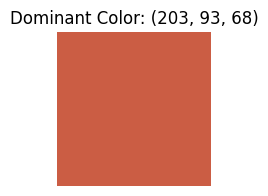

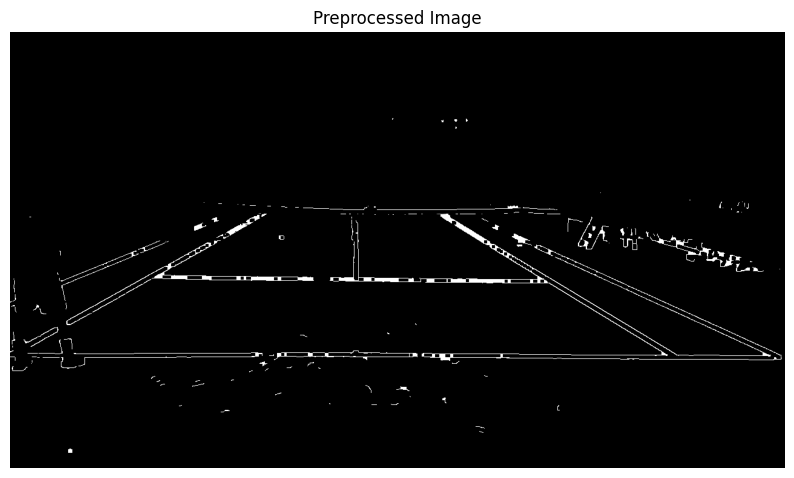

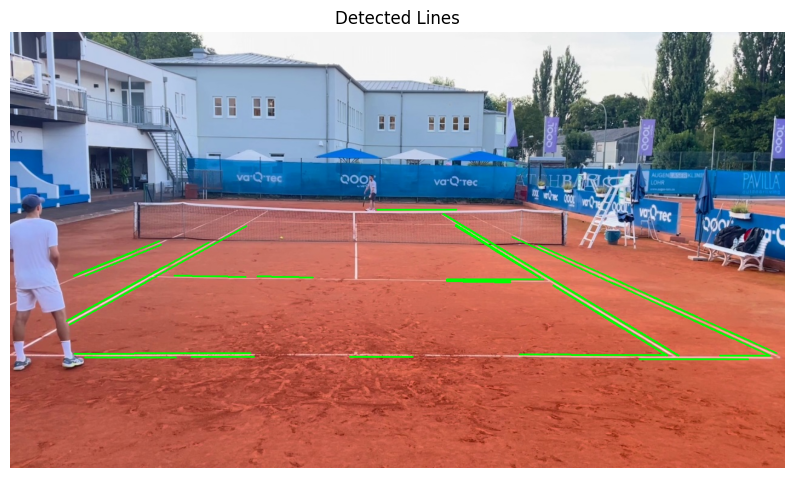

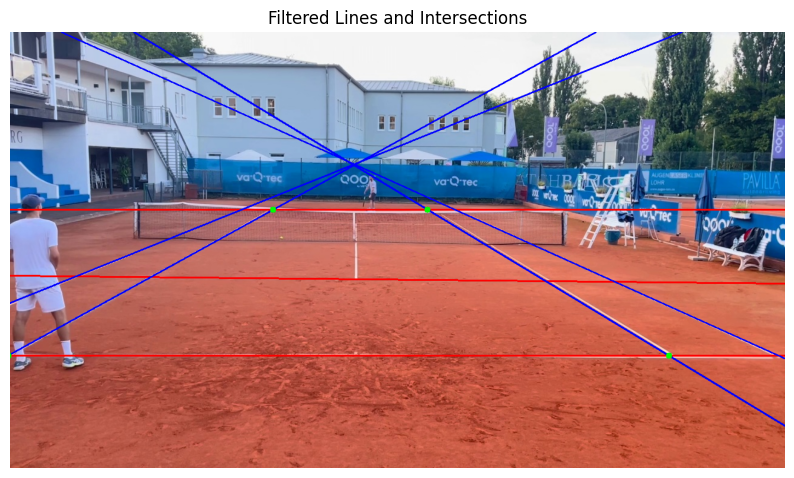

In [13]:
# Example usage
input_image = get_random_image(data_court)[0]
horizontal_lines, vertical_lines, intersections = detect_court_lines(input_image, plot=True)

In [221]:
max_distance = {'value': 0, 'gt_point': None, 'pred_point': None}

def calculate_error(input_path, frame_keypoints, plot=False):
    global max_distance
    error = 0
    horizontal_lines, vertical_lines, intersections = detect_court_lines(input_path, params=HYPERPARAMETERS, plot=plot)
    corners = {}
    if len(intersections) == 4:
        #top left corner
        corners['top_left_corner'] = intersections[0] 
        #top right corner
        corners['top_right_corner'] = intersections[1] 
        #bottom left corner
        corners['bottom_left_corner'] = intersections[2]
        #bottom right corner
        corners['bottom_right_corner'] = intersections[3]

        #mean sqared euclidean disance
        for key,value in corners.items():
            gt = frame_keypoints[key]
            # Replace the existing calculation
            error_key = euclidean(gt, value)**2
            if error_key > max_distance['value']:
                max_distance['value'] = error_key
                max_distance['gt_point'] = gt
                max_distance['pred_point'] = value
            error += error_key

        return error/4
    
    else:

        #large value to force a minimum of 4 lines
        return 10000000

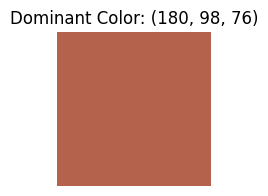

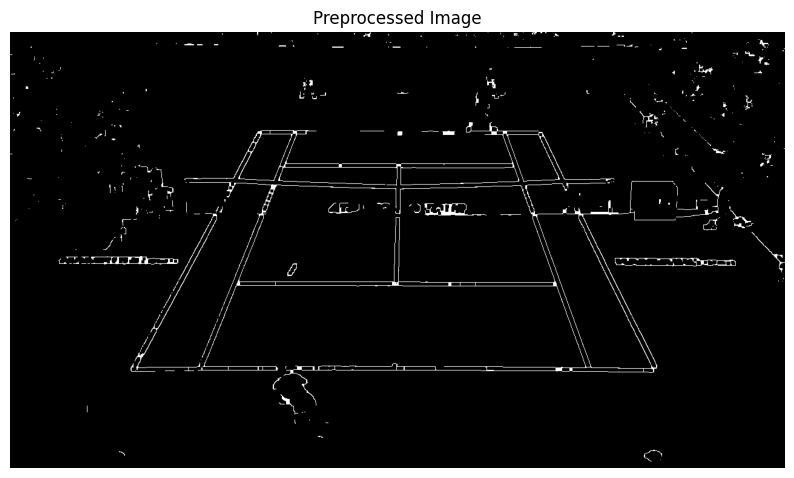

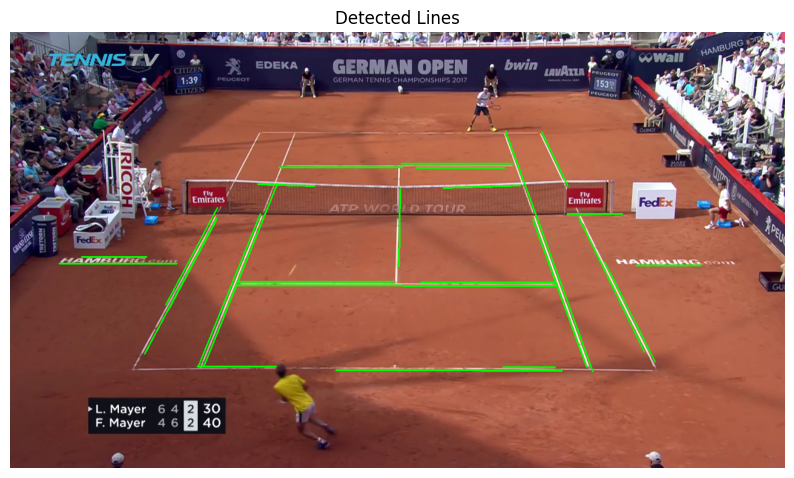

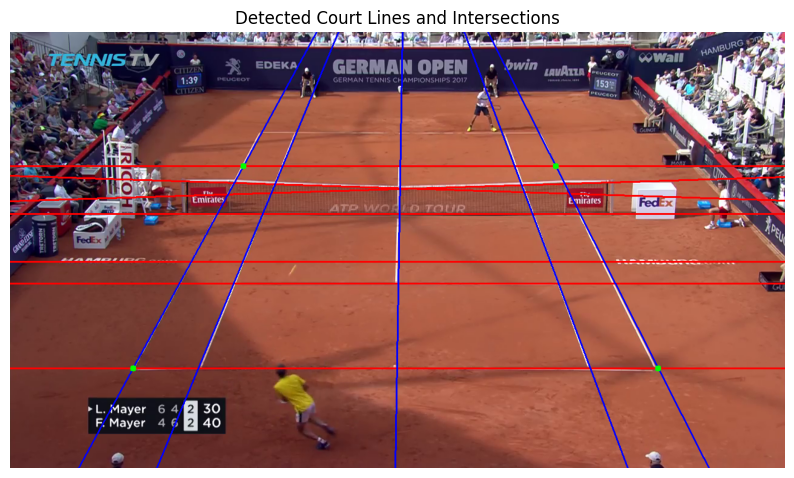

[(385, 221), (901, 221), (203, 555), (1070, 555)]


1912.25

In [218]:
# Example usage
input_image, frame = get_random_image(data_court)
calculate_error(input_image, frame, plot=True)

In [214]:
max_distance

{'value': 82723.99999999999, 'gt_point': [492, 207], 'pred_point': (260, 377)}

## Hyperparameter tuning using WandB

In [222]:
# loop over entire dataset
def evaluate_hyperparameters(data):
    errors = []
    for subset in data['subsets']:
        for video in subset['videos']:
            for clip in video['clips']:
                for frame, value in clip['frames_with_objects'].items():
                    if value['split'] != 'test':
                        path = '../FinalDataset/' + subset['name'] + '/' + video['name'] + '/' + clip['name'] + '/' + frame +".jpg"
                        error = calculate_error(path, clip['frames_with_objects'][frame]['keypoints'][0]['points'])
                        errors.append(error)

    # calculate mean
    return sum(errors)/len(errors), errors

# Example usage
mean_error, errors = evaluate_hyperparameters(data_court)

In [227]:
import wandb

# Define the hyperparameter search space
SWEEP_CONFIG = {
    "method": "bayes",  # Use Bayesian optimization
    "metric": {"name": "mean_error", "goal": "minimize"},
    "parameters": {
        "hsv_lower_delta": {"min": 5, "max": 20},        # Lower HSV range adjustment
        "hsv_upper_delta": {"min": 5, "max": 20},        # Upper HSV range adjustment
        "canny_threshold1": {"min": 50, "max": 200},     # First threshold for Canny edge detection
        "canny_threshold2": {"min": 100, "max": 250},    # Second threshold for Canny edge detection
        "hough_threshold": {"min": 50, "max": 200},      # Threshold for Hough Line Transform
        "hough_min_line_length": {"min": 50, "max": 300}, # Minimum line length for Hough
        "hough_max_line_gap": {"min": 5, "max": 50},     # Maximum allowed gap for Hough
        "horizontal_angle_thresh": {"min": 1, "max": 10}, # Horizontal line angle threshold
        "group_threshold": {"min": 10, "max": 50},       # Proximity threshold for grouping lines
        "dialate_iterations": {"values": [1, 2, 3]},     # Number of dilation iterations (discrete values)
    },
}

# Initialize the sweep
sweep_id = wandb.sweep(SWEEP_CONFIG, project="tennis-court")

# Define the training function for hyperparameter tuning
def train():
    # Initialize a wandb run
    with wandb.init() as run:
        # Get the current set of hyperparameters from wandb
        config = run.config

        # Update the global HYPERPARAMETERS dict
        global HYPERPARAMETERS

        HYPERPARAMETERS.update({
            "hsv_lower_delta": config.hsv_lower_delta,
            "hsv_upper_delta": config.hsv_upper_delta,
            "canny_threshold1": config.canny_threshold1,
            "canny_threshold2": config.canny_threshold2,
            "hough_threshold": config.hough_threshold,
            "hough_min_line_length": config.hough_min_line_length,
            "hough_max_line_gap": config.hough_max_line_gap,
            "horizontal_angle_thresh": config.horizontal_angle_thresh,
            "group_threshold": config.group_threshold,
            "dialate_iterations": config.dialate_iterations,
        })

        print ("HYPERPARAMETERS: ", HYPERPARAMETERS)

        # Evaluate the dataset with the current hyperparameters
        mean_error, errors = evaluate_hyperparameters(data_court)

        # Log metrics and hyperparameters
        wandb.log({
            "mean_error": mean_error
        })


# Run the sweep
wandb.agent(sweep_id, function=train, count=100)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: g2c6re7h
Sweep URL: https://wandb.ai/MasterarbeitBV/tennis-court/sweeps/g2c6re7h


wandb: Agent Starting Run: w76yaf6v with config:
wandb: 	canny_threshold1: 88
wandb: 	canny_threshold2: 174
wandb: 	dialate_iterations: 1
wandb: 	group_threshold: 30
wandb: 	horizontal_angle_thresh: 6
wandb: 	hough_max_line_gap: 42
wandb: 	hough_min_line_length: 195
wandb: 	hough_threshold: 182
wandb: 	hsv_lower_delta: 19
wandb: 	hsv_upper_delta: 18
wandb: Currently logged in as: spleedy (MasterarbeitBV). Use `wandb login --relogin` to force relogin


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 19, 'hsv_upper_delta': 18, 'canny_threshold1': 88, 'canny_threshold2': 174, 'morph_kernel_size': (5, 5), 'hough_threshold': 182, 'hough_min_line_length': 195, 'hough_max_line_gap': 42, 'horizontal_angle_thresh': 6, 'group_threshold': 30, 'intersection_radius': 5, 'dialate_iterations': 1}


wandb: Agent Starting Run: krvm9e5h with config:
wandb: 	canny_threshold1: 136
wandb: 	canny_threshold2: 215
wandb: 	dialate_iterations: 2
wandb: 	group_threshold: 25
wandb: 	horizontal_angle_thresh: 3
wandb: 	hough_max_line_gap: 21
wandb: 	hough_min_line_length: 142
wandb: 	hough_threshold: 110
wandb: 	hsv_lower_delta: 6
wandb: 	hsv_upper_delta: 15


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 6, 'hsv_upper_delta': 15, 'canny_threshold1': 136, 'canny_threshold2': 215, 'morph_kernel_size': (5, 5), 'hough_threshold': 110, 'hough_min_line_length': 142, 'hough_max_line_gap': 21, 'horizontal_angle_thresh': 3, 'group_threshold': 25, 'intersection_radius': 5, 'dialate_iterations': 2}


wandb: Agent Starting Run: rqo0lxfd with config:
wandb: 	canny_threshold1: 178
wandb: 	canny_threshold2: 128
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 29
wandb: 	horizontal_angle_thresh: 1
wandb: 	hough_max_line_gap: 38
wandb: 	hough_min_line_length: 60
wandb: 	hough_threshold: 134
wandb: 	hsv_lower_delta: 11
wandb: 	hsv_upper_delta: 6


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 11, 'hsv_upper_delta': 6, 'canny_threshold1': 178, 'canny_threshold2': 128, 'morph_kernel_size': (5, 5), 'hough_threshold': 134, 'hough_min_line_length': 60, 'hough_max_line_gap': 38, 'horizontal_angle_thresh': 1, 'group_threshold': 29, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: f4bd1sxj with config:
wandb: 	canny_threshold1: 79
wandb: 	canny_threshold2: 107
wandb: 	dialate_iterations: 2
wandb: 	group_threshold: 49
wandb: 	horizontal_angle_thresh: 6
wandb: 	hough_max_line_gap: 7
wandb: 	hough_min_line_length: 189
wandb: 	hough_threshold: 122
wandb: 	hsv_lower_delta: 17
wandb: 	hsv_upper_delta: 5


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 17, 'hsv_upper_delta': 5, 'canny_threshold1': 79, 'canny_threshold2': 107, 'morph_kernel_size': (5, 5), 'hough_threshold': 122, 'hough_min_line_length': 189, 'hough_max_line_gap': 7, 'horizontal_angle_thresh': 6, 'group_threshold': 49, 'intersection_radius': 5, 'dialate_iterations': 2}


wandb: Agent Starting Run: objoes5g with config:
wandb: 	canny_threshold1: 95
wandb: 	canny_threshold2: 101
wandb: 	dialate_iterations: 1
wandb: 	group_threshold: 19
wandb: 	horizontal_angle_thresh: 10
wandb: 	hough_max_line_gap: 35
wandb: 	hough_min_line_length: 206
wandb: 	hough_threshold: 69
wandb: 	hsv_lower_delta: 18
wandb: 	hsv_upper_delta: 15


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 18, 'hsv_upper_delta': 15, 'canny_threshold1': 95, 'canny_threshold2': 101, 'morph_kernel_size': (5, 5), 'hough_threshold': 69, 'hough_min_line_length': 206, 'hough_max_line_gap': 35, 'horizontal_angle_thresh': 10, 'group_threshold': 19, 'intersection_radius': 5, 'dialate_iterations': 1}


wandb: Agent Starting Run: ylez8282 with config:
wandb: 	canny_threshold1: 144
wandb: 	canny_threshold2: 224
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 31
wandb: 	horizontal_angle_thresh: 4
wandb: 	hough_max_line_gap: 27
wandb: 	hough_min_line_length: 172
wandb: 	hough_threshold: 122
wandb: 	hsv_lower_delta: 9
wandb: 	hsv_upper_delta: 16


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 9, 'hsv_upper_delta': 16, 'canny_threshold1': 144, 'canny_threshold2': 224, 'morph_kernel_size': (5, 5), 'hough_threshold': 122, 'hough_min_line_length': 172, 'hough_max_line_gap': 27, 'horizontal_angle_thresh': 4, 'group_threshold': 31, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: dc8yytv7 with config:
wandb: 	canny_threshold1: 198
wandb: 	canny_threshold2: 238
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 27
wandb: 	horizontal_angle_thresh: 4
wandb: 	hough_max_line_gap: 25
wandb: 	hough_min_line_length: 132
wandb: 	hough_threshold: 189
wandb: 	hsv_lower_delta: 5
wandb: 	hsv_upper_delta: 17


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 5, 'hsv_upper_delta': 17, 'canny_threshold1': 198, 'canny_threshold2': 238, 'morph_kernel_size': (5, 5), 'hough_threshold': 189, 'hough_min_line_length': 132, 'hough_max_line_gap': 25, 'horizontal_angle_thresh': 4, 'group_threshold': 27, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: ugkanr5i with config:
wandb: 	canny_threshold1: 149
wandb: 	canny_threshold2: 226
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 28
wandb: 	horizontal_angle_thresh: 4
wandb: 	hough_max_line_gap: 19
wandb: 	hough_min_line_length: 234
wandb: 	hough_threshold: 99
wandb: 	hsv_lower_delta: 9
wandb: 	hsv_upper_delta: 17


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 9, 'hsv_upper_delta': 17, 'canny_threshold1': 149, 'canny_threshold2': 226, 'morph_kernel_size': (5, 5), 'hough_threshold': 99, 'hough_min_line_length': 234, 'hough_max_line_gap': 19, 'horizontal_angle_thresh': 4, 'group_threshold': 28, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: s1jvm24n with config:
wandb: 	canny_threshold1: 65
wandb: 	canny_threshold2: 207
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 30
wandb: 	horizontal_angle_thresh: 4
wandb: 	hough_max_line_gap: 24
wandb: 	hough_min_line_length: 183
wandb: 	hough_threshold: 121
wandb: 	hsv_lower_delta: 7
wandb: 	hsv_upper_delta: 11


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 7, 'hsv_upper_delta': 11, 'canny_threshold1': 65, 'canny_threshold2': 207, 'morph_kernel_size': (5, 5), 'hough_threshold': 121, 'hough_min_line_length': 183, 'hough_max_line_gap': 24, 'horizontal_angle_thresh': 4, 'group_threshold': 30, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: u8mvdejz with config:
wandb: 	canny_threshold1: 58
wandb: 	canny_threshold2: 233
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 38
wandb: 	horizontal_angle_thresh: 2
wandb: 	hough_max_line_gap: 28
wandb: 	hough_min_line_length: 161
wandb: 	hough_threshold: 132
wandb: 	hsv_lower_delta: 9
wandb: 	hsv_upper_delta: 15


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 9, 'hsv_upper_delta': 15, 'canny_threshold1': 58, 'canny_threshold2': 233, 'morph_kernel_size': (5, 5), 'hough_threshold': 132, 'hough_min_line_length': 161, 'hough_max_line_gap': 28, 'horizontal_angle_thresh': 2, 'group_threshold': 38, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 8u8jtg0m with config:
wandb: 	canny_threshold1: 110
wandb: 	canny_threshold2: 220
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 24
wandb: 	horizontal_angle_thresh: 4
wandb: 	hough_max_line_gap: 24
wandb: 	hough_min_line_length: 74
wandb: 	hough_threshold: 127
wandb: 	hsv_lower_delta: 7
wandb: 	hsv_upper_delta: 6


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 7, 'hsv_upper_delta': 6, 'canny_threshold1': 110, 'canny_threshold2': 220, 'morph_kernel_size': (5, 5), 'hough_threshold': 127, 'hough_min_line_length': 74, 'hough_max_line_gap': 24, 'horizontal_angle_thresh': 4, 'group_threshold': 24, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: h3meaadf with config:
wandb: 	canny_threshold1: 114
wandb: 	canny_threshold2: 247
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 43
wandb: 	horizontal_angle_thresh: 6
wandb: 	hough_max_line_gap: 36
wandb: 	hough_min_line_length: 130
wandb: 	hough_threshold: 80
wandb: 	hsv_lower_delta: 8
wandb: 	hsv_upper_delta: 11


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 8, 'hsv_upper_delta': 11, 'canny_threshold1': 114, 'canny_threshold2': 247, 'morph_kernel_size': (5, 5), 'hough_threshold': 80, 'hough_min_line_length': 130, 'hough_max_line_gap': 36, 'horizontal_angle_thresh': 6, 'group_threshold': 43, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: gdyzsg4q with config:
wandb: 	canny_threshold1: 115
wandb: 	canny_threshold2: 221
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 34
wandb: 	horizontal_angle_thresh: 1
wandb: 	hough_max_line_gap: 33
wandb: 	hough_min_line_length: 176
wandb: 	hough_threshold: 55
wandb: 	hsv_lower_delta: 7
wandb: 	hsv_upper_delta: 7


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 7, 'hsv_upper_delta': 7, 'canny_threshold1': 115, 'canny_threshold2': 221, 'morph_kernel_size': (5, 5), 'hough_threshold': 55, 'hough_min_line_length': 176, 'hough_max_line_gap': 33, 'horizontal_angle_thresh': 1, 'group_threshold': 34, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gnf82arn with config:
wandb: 	canny_threshold1: 113
wandb: 	canny_threshold2: 151
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 49
wandb: 	horizontal_angle_thresh: 4
wandb: 	hough_max_line_gap: 22
wandb: 	hough_min_line_length: 139
wandb: 	hough_threshold: 110
wandb: 	hsv_lower_delta: 5
wandb: 	hsv_upper_delta: 15


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 5, 'hsv_upper_delta': 15, 'canny_threshold1': 113, 'canny_threshold2': 151, 'morph_kernel_size': (5, 5), 'hough_threshold': 110, 'hough_min_line_length': 139, 'hough_max_line_gap': 22, 'horizontal_angle_thresh': 4, 'group_threshold': 49, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: n3aym3sp with config:
wandb: 	canny_threshold1: 102
wandb: 	canny_threshold2: 224
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 34
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 9
wandb: 	hough_min_line_length: 58
wandb: 	hough_threshold: 129
wandb: 	hsv_lower_delta: 12
wandb: 	hsv_upper_delta: 16


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 12, 'hsv_upper_delta': 16, 'canny_threshold1': 102, 'canny_threshold2': 224, 'morph_kernel_size': (5, 5), 'hough_threshold': 129, 'hough_min_line_length': 58, 'hough_max_line_gap': 9, 'horizontal_angle_thresh': 5, 'group_threshold': 34, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 4lotrfjd with config:
wandb: 	canny_threshold1: 75
wandb: 	canny_threshold2: 191
wandb: 	dialate_iterations: 2
wandb: 	group_threshold: 43
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 12
wandb: 	hough_min_line_length: 108
wandb: 	hough_threshold: 164
wandb: 	hsv_lower_delta: 8
wandb: 	hsv_upper_delta: 13


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 8, 'hsv_upper_delta': 13, 'canny_threshold1': 75, 'canny_threshold2': 191, 'morph_kernel_size': (5, 5), 'hough_threshold': 164, 'hough_min_line_length': 108, 'hough_max_line_gap': 12, 'horizontal_angle_thresh': 5, 'group_threshold': 43, 'intersection_radius': 5, 'dialate_iterations': 2}


wandb: Agent Starting Run: mei9fihd with config:
wandb: 	canny_threshold1: 94
wandb: 	canny_threshold2: 210
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 45
wandb: 	horizontal_angle_thresh: 9
wandb: 	hough_max_line_gap: 11
wandb: 	hough_min_line_length: 99
wandb: 	hough_threshold: 127
wandb: 	hsv_lower_delta: 7
wandb: 	hsv_upper_delta: 10


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 7, 'hsv_upper_delta': 10, 'canny_threshold1': 94, 'canny_threshold2': 210, 'morph_kernel_size': (5, 5), 'hough_threshold': 127, 'hough_min_line_length': 99, 'hough_max_line_gap': 11, 'horizontal_angle_thresh': 9, 'group_threshold': 45, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: m4foif0k with config:
wandb: 	canny_threshold1: 88
wandb: 	canny_threshold2: 153
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 29
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 8
wandb: 	hough_min_line_length: 149
wandb: 	hough_threshold: 132
wandb: 	hsv_lower_delta: 9
wandb: 	hsv_upper_delta: 10


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 9, 'hsv_upper_delta': 10, 'canny_threshold1': 88, 'canny_threshold2': 153, 'morph_kernel_size': (5, 5), 'hough_threshold': 132, 'hough_min_line_length': 149, 'hough_max_line_gap': 8, 'horizontal_angle_thresh': 5, 'group_threshold': 29, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: l8la7wqq with config:
wandb: 	canny_threshold1: 121
wandb: 	canny_threshold2: 228
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 49
wandb: 	horizontal_angle_thresh: 7
wandb: 	hough_max_line_gap: 7
wandb: 	hough_min_line_length: 213
wandb: 	hough_threshold: 133
wandb: 	hsv_lower_delta: 7
wandb: 	hsv_upper_delta: 11


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 7, 'hsv_upper_delta': 11, 'canny_threshold1': 121, 'canny_threshold2': 228, 'morph_kernel_size': (5, 5), 'hough_threshold': 133, 'hough_min_line_length': 213, 'hough_max_line_gap': 7, 'horizontal_angle_thresh': 7, 'group_threshold': 49, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2tdd2awn with config:
wandb: 	canny_threshold1: 122
wandb: 	canny_threshold2: 218
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 33
wandb: 	horizontal_angle_thresh: 6
wandb: 	hough_max_line_gap: 14
wandb: 	hough_min_line_length: 92
wandb: 	hough_threshold: 114
wandb: 	hsv_lower_delta: 5
wandb: 	hsv_upper_delta: 14


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 5, 'hsv_upper_delta': 14, 'canny_threshold1': 122, 'canny_threshold2': 218, 'morph_kernel_size': (5, 5), 'hough_threshold': 114, 'hough_min_line_length': 92, 'hough_max_line_gap': 14, 'horizontal_angle_thresh': 6, 'group_threshold': 33, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 97g7sigj with config:
wandb: 	canny_threshold1: 58
wandb: 	canny_threshold2: 195
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 22
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 24
wandb: 	hough_min_line_length: 81
wandb: 	hough_threshold: 140
wandb: 	hsv_lower_delta: 8
wandb: 	hsv_upper_delta: 14


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 8, 'hsv_upper_delta': 14, 'canny_threshold1': 58, 'canny_threshold2': 195, 'morph_kernel_size': (5, 5), 'hough_threshold': 140, 'hough_min_line_length': 81, 'hough_max_line_gap': 24, 'horizontal_angle_thresh': 5, 'group_threshold': 22, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: q46h5qx5 with config:
wandb: 	canny_threshold1: 94
wandb: 	canny_threshold2: 207
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 30
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 25
wandb: 	hough_min_line_length: 159
wandb: 	hough_threshold: 83
wandb: 	hsv_lower_delta: 8
wandb: 	hsv_upper_delta: 15


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 8, 'hsv_upper_delta': 15, 'canny_threshold1': 94, 'canny_threshold2': 207, 'morph_kernel_size': (5, 5), 'hough_threshold': 83, 'hough_min_line_length': 159, 'hough_max_line_gap': 25, 'horizontal_angle_thresh': 5, 'group_threshold': 30, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 4rancduj with config:
wandb: 	canny_threshold1: 95
wandb: 	canny_threshold2: 167
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 40
wandb: 	horizontal_angle_thresh: 10
wandb: 	hough_max_line_gap: 19
wandb: 	hough_min_line_length: 66
wandb: 	hough_threshold: 141
wandb: 	hsv_lower_delta: 12
wandb: 	hsv_upper_delta: 5


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 12, 'hsv_upper_delta': 5, 'canny_threshold1': 95, 'canny_threshold2': 167, 'morph_kernel_size': (5, 5), 'hough_threshold': 141, 'hough_min_line_length': 66, 'hough_max_line_gap': 19, 'horizontal_angle_thresh': 10, 'group_threshold': 40, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: ixjgwjx1 with config:
wandb: 	canny_threshold1: 107
wandb: 	canny_threshold2: 207
wandb: 	dialate_iterations: 2
wandb: 	group_threshold: 40
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 16
wandb: 	hough_min_line_length: 51
wandb: 	hough_threshold: 118
wandb: 	hsv_lower_delta: 9
wandb: 	hsv_upper_delta: 13


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 9, 'hsv_upper_delta': 13, 'canny_threshold1': 107, 'canny_threshold2': 207, 'morph_kernel_size': (5, 5), 'hough_threshold': 118, 'hough_min_line_length': 51, 'hough_max_line_gap': 16, 'horizontal_angle_thresh': 5, 'group_threshold': 40, 'intersection_radius': 5, 'dialate_iterations': 2}


wandb: Agent Starting Run: 63pa9qyb with config:
wandb: 	canny_threshold1: 63
wandb: 	canny_threshold2: 228
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 30
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 8
wandb: 	hough_min_line_length: 58
wandb: 	hough_threshold: 124
wandb: 	hsv_lower_delta: 8
wandb: 	hsv_upper_delta: 5


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 8, 'hsv_upper_delta': 5, 'canny_threshold1': 63, 'canny_threshold2': 228, 'morph_kernel_size': (5, 5), 'hough_threshold': 124, 'hough_min_line_length': 58, 'hough_max_line_gap': 8, 'horizontal_angle_thresh': 8, 'group_threshold': 30, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 72lcrusa with config:
wandb: 	canny_threshold1: 103
wandb: 	canny_threshold2: 237
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 10
wandb: 	horizontal_angle_thresh: 3
wandb: 	hough_max_line_gap: 5
wandb: 	hough_min_line_length: 130
wandb: 	hough_threshold: 130
wandb: 	hsv_lower_delta: 5
wandb: 	hsv_upper_delta: 14


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 5, 'hsv_upper_delta': 14, 'canny_threshold1': 103, 'canny_threshold2': 237, 'morph_kernel_size': (5, 5), 'hough_threshold': 130, 'hough_min_line_length': 130, 'hough_max_line_gap': 5, 'horizontal_angle_thresh': 3, 'group_threshold': 10, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Network error (ConnectionError), entering retry loop.


wandb: Agent Starting Run: bjcdhgeq with config:
wandb: 	canny_threshold1: 81
wandb: 	canny_threshold2: 182
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 35
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 27
wandb: 	hough_min_line_length: 63
wandb: 	hough_threshold: 149
wandb: 	hsv_lower_delta: 6
wandb: 	hsv_upper_delta: 8


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 6, 'hsv_upper_delta': 8, 'canny_threshold1': 81, 'canny_threshold2': 182, 'morph_kernel_size': (5, 5), 'hough_threshold': 149, 'hough_min_line_length': 63, 'hough_max_line_gap': 27, 'horizontal_angle_thresh': 8, 'group_threshold': 35, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: q3hlwili with config:
wandb: 	canny_threshold1: 61
wandb: 	canny_threshold2: 125
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 44
wandb: 	horizontal_angle_thresh: 3
wandb: 	hough_max_line_gap: 17
wandb: 	hough_min_line_length: 76
wandb: 	hough_threshold: 144
wandb: 	hsv_lower_delta: 8
wandb: 	hsv_upper_delta: 5


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 8, 'hsv_upper_delta': 5, 'canny_threshold1': 61, 'canny_threshold2': 125, 'morph_kernel_size': (5, 5), 'hough_threshold': 144, 'hough_min_line_length': 76, 'hough_max_line_gap': 17, 'horizontal_angle_thresh': 3, 'group_threshold': 44, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qn7z0vzd with config:
wandb: 	canny_threshold1: 89
wandb: 	canny_threshold2: 162
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 40
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 9
wandb: 	hough_min_line_length: 59
wandb: 	hough_threshold: 174
wandb: 	hsv_lower_delta: 12
wandb: 	hsv_upper_delta: 17


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 12, 'hsv_upper_delta': 17, 'canny_threshold1': 89, 'canny_threshold2': 162, 'morph_kernel_size': (5, 5), 'hough_threshold': 174, 'hough_min_line_length': 59, 'hough_max_line_gap': 9, 'horizontal_angle_thresh': 8, 'group_threshold': 40, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: r0lxsino with config:
wandb: 	canny_threshold1: 131
wandb: 	canny_threshold2: 223
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 19
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 13
wandb: 	hough_min_line_length: 111
wandb: 	hough_threshold: 114
wandb: 	hsv_lower_delta: 9
wandb: 	hsv_upper_delta: 18


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 9, 'hsv_upper_delta': 18, 'canny_threshold1': 131, 'canny_threshold2': 223, 'morph_kernel_size': (5, 5), 'hough_threshold': 114, 'hough_min_line_length': 111, 'hough_max_line_gap': 13, 'horizontal_angle_thresh': 5, 'group_threshold': 19, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 6uq3fhzu with config:
wandb: 	canny_threshold1: 97
wandb: 	canny_threshold2: 133
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 26
wandb: 	horizontal_angle_thresh: 4
wandb: 	hough_max_line_gap: 5
wandb: 	hough_min_line_length: 57
wandb: 	hough_threshold: 171
wandb: 	hsv_lower_delta: 12
wandb: 	hsv_upper_delta: 18


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 12, 'hsv_upper_delta': 18, 'canny_threshold1': 97, 'canny_threshold2': 133, 'morph_kernel_size': (5, 5), 'hough_threshold': 171, 'hough_min_line_length': 57, 'hough_max_line_gap': 5, 'horizontal_angle_thresh': 4, 'group_threshold': 26, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: twsd1vex with config:
wandb: 	canny_threshold1: 87
wandb: 	canny_threshold2: 134
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 11
wandb: 	horizontal_angle_thresh: 2
wandb: 	hough_max_line_gap: 13
wandb: 	hough_min_line_length: 114
wandb: 	hough_threshold: 161
wandb: 	hsv_lower_delta: 7
wandb: 	hsv_upper_delta: 16


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 7, 'hsv_upper_delta': 16, 'canny_threshold1': 87, 'canny_threshold2': 134, 'morph_kernel_size': (5, 5), 'hough_threshold': 161, 'hough_min_line_length': 114, 'hough_max_line_gap': 13, 'horizontal_angle_thresh': 2, 'group_threshold': 11, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: rcqs0aex with config:
wandb: 	canny_threshold1: 155
wandb: 	canny_threshold2: 157
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 26
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 10
wandb: 	hough_min_line_length: 62
wandb: 	hough_threshold: 95
wandb: 	hsv_lower_delta: 9
wandb: 	hsv_upper_delta: 20


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 9, 'hsv_upper_delta': 20, 'canny_threshold1': 155, 'canny_threshold2': 157, 'morph_kernel_size': (5, 5), 'hough_threshold': 95, 'hough_min_line_length': 62, 'hough_max_line_gap': 10, 'horizontal_angle_thresh': 5, 'group_threshold': 26, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 73oq903m with config:
wandb: 	canny_threshold1: 81
wandb: 	canny_threshold2: 129
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 45
wandb: 	horizontal_angle_thresh: 7
wandb: 	hough_max_line_gap: 18
wandb: 	hough_min_line_length: 110
wandb: 	hough_threshold: 156
wandb: 	hsv_lower_delta: 13
wandb: 	hsv_upper_delta: 19


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 13, 'hsv_upper_delta': 19, 'canny_threshold1': 81, 'canny_threshold2': 129, 'morph_kernel_size': (5, 5), 'hough_threshold': 156, 'hough_min_line_length': 110, 'hough_max_line_gap': 18, 'horizontal_angle_thresh': 7, 'group_threshold': 45, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: rv70bagg with config:
wandb: 	canny_threshold1: 68
wandb: 	canny_threshold2: 142
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 49
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 8
wandb: 	hough_min_line_length: 87
wandb: 	hough_threshold: 181
wandb: 	hsv_lower_delta: 15
wandb: 	hsv_upper_delta: 15


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 15, 'hsv_upper_delta': 15, 'canny_threshold1': 68, 'canny_threshold2': 142, 'morph_kernel_size': (5, 5), 'hough_threshold': 181, 'hough_min_line_length': 87, 'hough_max_line_gap': 8, 'horizontal_angle_thresh': 5, 'group_threshold': 49, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: o8vriwcq with config:
wandb: 	canny_threshold1: 120
wandb: 	canny_threshold2: 134
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 35
wandb: 	horizontal_angle_thresh: 4
wandb: 	hough_max_line_gap: 14
wandb: 	hough_min_line_length: 164
wandb: 	hough_threshold: 138
wandb: 	hsv_lower_delta: 5
wandb: 	hsv_upper_delta: 20


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 5, 'hsv_upper_delta': 20, 'canny_threshold1': 120, 'canny_threshold2': 134, 'morph_kernel_size': (5, 5), 'hough_threshold': 138, 'hough_min_line_length': 164, 'hough_max_line_gap': 14, 'horizontal_angle_thresh': 4, 'group_threshold': 35, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: y7bkamsj with config:
wandb: 	canny_threshold1: 148
wandb: 	canny_threshold2: 133
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 28
wandb: 	horizontal_angle_thresh: 4
wandb: 	hough_max_line_gap: 7
wandb: 	hough_min_line_length: 128
wandb: 	hough_threshold: 153
wandb: 	hsv_lower_delta: 7
wandb: 	hsv_upper_delta: 17


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 7, 'hsv_upper_delta': 17, 'canny_threshold1': 148, 'canny_threshold2': 133, 'morph_kernel_size': (5, 5), 'hough_threshold': 153, 'hough_min_line_length': 128, 'hough_max_line_gap': 7, 'horizontal_angle_thresh': 4, 'group_threshold': 28, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: ua4q9363 with config:
wandb: 	canny_threshold1: 110
wandb: 	canny_threshold2: 196
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 31
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 13
wandb: 	hough_min_line_length: 77
wandb: 	hough_threshold: 176
wandb: 	hsv_lower_delta: 9
wandb: 	hsv_upper_delta: 17


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 9, 'hsv_upper_delta': 17, 'canny_threshold1': 110, 'canny_threshold2': 196, 'morph_kernel_size': (5, 5), 'hough_threshold': 176, 'hough_min_line_length': 77, 'hough_max_line_gap': 13, 'horizontal_angle_thresh': 8, 'group_threshold': 31, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: ubkxrm62 with config:
wandb: 	canny_threshold1: 83
wandb: 	canny_threshold2: 135
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 37
wandb: 	horizontal_angle_thresh: 6
wandb: 	hough_max_line_gap: 13
wandb: 	hough_min_line_length: 111
wandb: 	hough_threshold: 184
wandb: 	hsv_lower_delta: 12
wandb: 	hsv_upper_delta: 19


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 12, 'hsv_upper_delta': 19, 'canny_threshold1': 83, 'canny_threshold2': 135, 'morph_kernel_size': (5, 5), 'hough_threshold': 184, 'hough_min_line_length': 111, 'hough_max_line_gap': 13, 'horizontal_angle_thresh': 6, 'group_threshold': 37, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: evl5riho with config:
wandb: 	canny_threshold1: 108
wandb: 	canny_threshold2: 100
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 22
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 5
wandb: 	hough_min_line_length: 78
wandb: 	hough_threshold: 189
wandb: 	hsv_lower_delta: 9
wandb: 	hsv_upper_delta: 11


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 9, 'hsv_upper_delta': 11, 'canny_threshold1': 108, 'canny_threshold2': 100, 'morph_kernel_size': (5, 5), 'hough_threshold': 189, 'hough_min_line_length': 78, 'hough_max_line_gap': 5, 'horizontal_angle_thresh': 8, 'group_threshold': 22, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: pptozlk4 with config:
wandb: 	canny_threshold1: 97
wandb: 	canny_threshold2: 195
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 31
wandb: 	horizontal_angle_thresh: 10
wandb: 	hough_max_line_gap: 11
wandb: 	hough_min_line_length: 54
wandb: 	hough_threshold: 144
wandb: 	hsv_lower_delta: 10
wandb: 	hsv_upper_delta: 15


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 10, 'hsv_upper_delta': 15, 'canny_threshold1': 97, 'canny_threshold2': 195, 'morph_kernel_size': (5, 5), 'hough_threshold': 144, 'hough_min_line_length': 54, 'hough_max_line_gap': 11, 'horizontal_angle_thresh': 10, 'group_threshold': 31, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: zui6t7h2 with config:
wandb: 	canny_threshold1: 97
wandb: 	canny_threshold2: 111
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 48
wandb: 	horizontal_angle_thresh: 9
wandb: 	hough_max_line_gap: 5
wandb: 	hough_min_line_length: 111
wandb: 	hough_threshold: 177
wandb: 	hsv_lower_delta: 6
wandb: 	hsv_upper_delta: 14


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 6, 'hsv_upper_delta': 14, 'canny_threshold1': 97, 'canny_threshold2': 111, 'morph_kernel_size': (5, 5), 'hough_threshold': 177, 'hough_min_line_length': 111, 'hough_max_line_gap': 5, 'horizontal_angle_thresh': 9, 'group_threshold': 48, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: gg7hb2tz with config:
wandb: 	canny_threshold1: 66
wandb: 	canny_threshold2: 198
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 22
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 10
wandb: 	hough_min_line_length: 179
wandb: 	hough_threshold: 139
wandb: 	hsv_lower_delta: 7
wandb: 	hsv_upper_delta: 13


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 7, 'hsv_upper_delta': 13, 'canny_threshold1': 66, 'canny_threshold2': 198, 'morph_kernel_size': (5, 5), 'hough_threshold': 139, 'hough_min_line_length': 179, 'hough_max_line_gap': 10, 'horizontal_angle_thresh': 5, 'group_threshold': 22, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 3usgw6ra with config:
wandb: 	canny_threshold1: 128
wandb: 	canny_threshold2: 131
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 24
wandb: 	horizontal_angle_thresh: 6
wandb: 	hough_max_line_gap: 10
wandb: 	hough_min_line_length: 73
wandb: 	hough_threshold: 185
wandb: 	hsv_lower_delta: 7
wandb: 	hsv_upper_delta: 19


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 7, 'hsv_upper_delta': 19, 'canny_threshold1': 128, 'canny_threshold2': 131, 'morph_kernel_size': (5, 5), 'hough_threshold': 185, 'hough_min_line_length': 73, 'hough_max_line_gap': 10, 'horizontal_angle_thresh': 6, 'group_threshold': 24, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 6iqluujf with config:
wandb: 	canny_threshold1: 109
wandb: 	canny_threshold2: 155
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 27
wandb: 	horizontal_angle_thresh: 7
wandb: 	hough_max_line_gap: 14
wandb: 	hough_min_line_length: 113
wandb: 	hough_threshold: 188
wandb: 	hsv_lower_delta: 10
wandb: 	hsv_upper_delta: 12


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 10, 'hsv_upper_delta': 12, 'canny_threshold1': 109, 'canny_threshold2': 155, 'morph_kernel_size': (5, 5), 'hough_threshold': 188, 'hough_min_line_length': 113, 'hough_max_line_gap': 14, 'horizontal_angle_thresh': 7, 'group_threshold': 27, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: q1eir82d with config:
wandb: 	canny_threshold1: 58
wandb: 	canny_threshold2: 135
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 36
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 6
wandb: 	hough_min_line_length: 112
wandb: 	hough_threshold: 180
wandb: 	hsv_lower_delta: 13
wandb: 	hsv_upper_delta: 19


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 13, 'hsv_upper_delta': 19, 'canny_threshold1': 58, 'canny_threshold2': 135, 'morph_kernel_size': (5, 5), 'hough_threshold': 180, 'hough_min_line_length': 112, 'hough_max_line_gap': 6, 'horizontal_angle_thresh': 5, 'group_threshold': 36, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: djh6y9au with config:
wandb: 	canny_threshold1: 80
wandb: 	canny_threshold2: 103
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 47
wandb: 	horizontal_angle_thresh: 6
wandb: 	hough_max_line_gap: 12
wandb: 	hough_min_line_length: 107
wandb: 	hough_threshold: 131
wandb: 	hsv_lower_delta: 5
wandb: 	hsv_upper_delta: 18


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 5, 'hsv_upper_delta': 18, 'canny_threshold1': 80, 'canny_threshold2': 103, 'morph_kernel_size': (5, 5), 'hough_threshold': 131, 'hough_min_line_length': 107, 'hough_max_line_gap': 12, 'horizontal_angle_thresh': 6, 'group_threshold': 47, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: p268u81a with config:
wandb: 	canny_threshold1: 58
wandb: 	canny_threshold2: 118
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 35
wandb: 	horizontal_angle_thresh: 9
wandb: 	hough_max_line_gap: 8
wandb: 	hough_min_line_length: 64
wandb: 	hough_threshold: 173
wandb: 	hsv_lower_delta: 8
wandb: 	hsv_upper_delta: 9


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 8, 'hsv_upper_delta': 9, 'canny_threshold1': 58, 'canny_threshold2': 118, 'morph_kernel_size': (5, 5), 'hough_threshold': 173, 'hough_min_line_length': 64, 'hough_max_line_gap': 8, 'horizontal_angle_thresh': 9, 'group_threshold': 35, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: wu7ckizf with config:
wandb: 	canny_threshold1: 92
wandb: 	canny_threshold2: 151
wandb: 	dialate_iterations: 2
wandb: 	group_threshold: 26
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 5
wandb: 	hough_min_line_length: 188
wandb: 	hough_threshold: 142
wandb: 	hsv_lower_delta: 5
wandb: 	hsv_upper_delta: 20


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 5, 'hsv_upper_delta': 20, 'canny_threshold1': 92, 'canny_threshold2': 151, 'morph_kernel_size': (5, 5), 'hough_threshold': 142, 'hough_min_line_length': 188, 'hough_max_line_gap': 5, 'horizontal_angle_thresh': 5, 'group_threshold': 26, 'intersection_radius': 5, 'dialate_iterations': 2}


wandb: Agent Starting Run: k8n5pglk with config:
wandb: 	canny_threshold1: 83
wandb: 	canny_threshold2: 160
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 11
wandb: 	horizontal_angle_thresh: 2
wandb: 	hough_max_line_gap: 13
wandb: 	hough_min_line_length: 147
wandb: 	hough_threshold: 122
wandb: 	hsv_lower_delta: 11
wandb: 	hsv_upper_delta: 8


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 11, 'hsv_upper_delta': 8, 'canny_threshold1': 83, 'canny_threshold2': 160, 'morph_kernel_size': (5, 5), 'hough_threshold': 122, 'hough_min_line_length': 147, 'hough_max_line_gap': 13, 'horizontal_angle_thresh': 2, 'group_threshold': 11, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: axm62pts with config:
wandb: 	canny_threshold1: 102
wandb: 	canny_threshold2: 126
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 34
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 10
wandb: 	hough_min_line_length: 81
wandb: 	hough_threshold: 169
wandb: 	hsv_lower_delta: 9
wandb: 	hsv_upper_delta: 17


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 9, 'hsv_upper_delta': 17, 'canny_threshold1': 102, 'canny_threshold2': 126, 'morph_kernel_size': (5, 5), 'hough_threshold': 169, 'hough_min_line_length': 81, 'hough_max_line_gap': 10, 'horizontal_angle_thresh': 5, 'group_threshold': 34, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 7tgr7mw7 with config:
wandb: 	canny_threshold1: 171
wandb: 	canny_threshold2: 117
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 40
wandb: 	horizontal_angle_thresh: 3
wandb: 	hough_max_line_gap: 31
wandb: 	hough_min_line_length: 207
wandb: 	hough_threshold: 155
wandb: 	hsv_lower_delta: 9
wandb: 	hsv_upper_delta: 20


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 9, 'hsv_upper_delta': 20, 'canny_threshold1': 171, 'canny_threshold2': 117, 'morph_kernel_size': (5, 5), 'hough_threshold': 155, 'hough_min_line_length': 207, 'hough_max_line_gap': 31, 'horizontal_angle_thresh': 3, 'group_threshold': 40, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 2zq8u1m1 with config:
wandb: 	canny_threshold1: 185
wandb: 	canny_threshold2: 100
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 33
wandb: 	horizontal_angle_thresh: 1
wandb: 	hough_max_line_gap: 33
wandb: 	hough_min_line_length: 287
wandb: 	hough_threshold: 145
wandb: 	hsv_lower_delta: 5
wandb: 	hsv_upper_delta: 19


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 5, 'hsv_upper_delta': 19, 'canny_threshold1': 185, 'canny_threshold2': 100, 'morph_kernel_size': (5, 5), 'hough_threshold': 145, 'hough_min_line_length': 287, 'hough_max_line_gap': 33, 'horizontal_angle_thresh': 1, 'group_threshold': 33, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: zgalizug with config:
wandb: 	canny_threshold1: 180
wandb: 	canny_threshold2: 102
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 49
wandb: 	horizontal_angle_thresh: 4
wandb: 	hough_max_line_gap: 5
wandb: 	hough_min_line_length: 159
wandb: 	hough_threshold: 173
wandb: 	hsv_lower_delta: 14
wandb: 	hsv_upper_delta: 14


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 14, 'hsv_upper_delta': 14, 'canny_threshold1': 180, 'canny_threshold2': 102, 'morph_kernel_size': (5, 5), 'hough_threshold': 173, 'hough_min_line_length': 159, 'hough_max_line_gap': 5, 'horizontal_angle_thresh': 4, 'group_threshold': 49, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: uszroai6 with config:
wandb: 	canny_threshold1: 151
wandb: 	canny_threshold2: 160
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 31
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 9
wandb: 	hough_min_line_length: 70
wandb: 	hough_threshold: 147
wandb: 	hsv_lower_delta: 5
wandb: 	hsv_upper_delta: 10


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 5, 'hsv_upper_delta': 10, 'canny_threshold1': 151, 'canny_threshold2': 160, 'morph_kernel_size': (5, 5), 'hough_threshold': 147, 'hough_min_line_length': 70, 'hough_max_line_gap': 9, 'horizontal_angle_thresh': 8, 'group_threshold': 31, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4sfgwv57 with config:
wandb: 	canny_threshold1: 134
wandb: 	canny_threshold2: 115
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 38
wandb: 	horizontal_angle_thresh: 9
wandb: 	hough_max_line_gap: 11
wandb: 	hough_min_line_length: 92
wandb: 	hough_threshold: 191
wandb: 	hsv_lower_delta: 8
wandb: 	hsv_upper_delta: 17


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 8, 'hsv_upper_delta': 17, 'canny_threshold1': 134, 'canny_threshold2': 115, 'morph_kernel_size': (5, 5), 'hough_threshold': 191, 'hough_min_line_length': 92, 'hough_max_line_gap': 11, 'horizontal_angle_thresh': 9, 'group_threshold': 38, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: ywsfdaum with config:
wandb: 	canny_threshold1: 72
wandb: 	canny_threshold2: 227
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 11
wandb: 	horizontal_angle_thresh: 2
wandb: 	hough_max_line_gap: 11
wandb: 	hough_min_line_length: 114
wandb: 	hough_threshold: 183
wandb: 	hsv_lower_delta: 17
wandb: 	hsv_upper_delta: 15


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 17, 'hsv_upper_delta': 15, 'canny_threshold1': 72, 'canny_threshold2': 227, 'morph_kernel_size': (5, 5), 'hough_threshold': 183, 'hough_min_line_length': 114, 'hough_max_line_gap': 11, 'horizontal_angle_thresh': 2, 'group_threshold': 11, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 783chfun with config:
wandb: 	canny_threshold1: 106
wandb: 	canny_threshold2: 217
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 17
wandb: 	horizontal_angle_thresh: 2
wandb: 	hough_max_line_gap: 27
wandb: 	hough_min_line_length: 109
wandb: 	hough_threshold: 118
wandb: 	hsv_lower_delta: 11
wandb: 	hsv_upper_delta: 17


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 11, 'hsv_upper_delta': 17, 'canny_threshold1': 106, 'canny_threshold2': 217, 'morph_kernel_size': (5, 5), 'hough_threshold': 118, 'hough_min_line_length': 109, 'hough_max_line_gap': 27, 'horizontal_angle_thresh': 2, 'group_threshold': 17, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 8hmfyjur with config:
wandb: 	canny_threshold1: 139
wandb: 	canny_threshold2: 169
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 31
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 18
wandb: 	hough_min_line_length: 93
wandb: 	hough_threshold: 143
wandb: 	hsv_lower_delta: 9
wandb: 	hsv_upper_delta: 16


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 9, 'hsv_upper_delta': 16, 'canny_threshold1': 139, 'canny_threshold2': 169, 'morph_kernel_size': (5, 5), 'hough_threshold': 143, 'hough_min_line_length': 93, 'hough_max_line_gap': 18, 'horizontal_angle_thresh': 5, 'group_threshold': 31, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: h9qv7m84 with config:
wandb: 	canny_threshold1: 79
wandb: 	canny_threshold2: 176
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 45
wandb: 	horizontal_angle_thresh: 3
wandb: 	hough_max_line_gap: 13
wandb: 	hough_min_line_length: 60
wandb: 	hough_threshold: 190
wandb: 	hsv_lower_delta: 18
wandb: 	hsv_upper_delta: 20


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 18, 'hsv_upper_delta': 20, 'canny_threshold1': 79, 'canny_threshold2': 176, 'morph_kernel_size': (5, 5), 'hough_threshold': 190, 'hough_min_line_length': 60, 'hough_max_line_gap': 13, 'horizontal_angle_thresh': 3, 'group_threshold': 45, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: rofab6w2 with config:
wandb: 	canny_threshold1: 85
wandb: 	canny_threshold2: 240
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 38
wandb: 	horizontal_angle_thresh: 6
wandb: 	hough_max_line_gap: 6
wandb: 	hough_min_line_length: 54
wandb: 	hough_threshold: 180
wandb: 	hsv_lower_delta: 18
wandb: 	hsv_upper_delta: 19


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 18, 'hsv_upper_delta': 19, 'canny_threshold1': 85, 'canny_threshold2': 240, 'morph_kernel_size': (5, 5), 'hough_threshold': 180, 'hough_min_line_length': 54, 'hough_max_line_gap': 6, 'horizontal_angle_thresh': 6, 'group_threshold': 38, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: d7ppe9cg with config:
wandb: 	canny_threshold1: 113
wandb: 	canny_threshold2: 183
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 17
wandb: 	horizontal_angle_thresh: 7
wandb: 	hough_max_line_gap: 11
wandb: 	hough_min_line_length: 147
wandb: 	hough_threshold: 130
wandb: 	hsv_lower_delta: 8
wandb: 	hsv_upper_delta: 7


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 8, 'hsv_upper_delta': 7, 'canny_threshold1': 113, 'canny_threshold2': 183, 'morph_kernel_size': (5, 5), 'hough_threshold': 130, 'hough_min_line_length': 147, 'hough_max_line_gap': 11, 'horizontal_angle_thresh': 7, 'group_threshold': 17, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: zoday6cm with config:
wandb: 	canny_threshold1: 84
wandb: 	canny_threshold2: 186
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 42
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 42
wandb: 	hough_min_line_length: 52
wandb: 	hough_threshold: 160
wandb: 	hsv_lower_delta: 5
wandb: 	hsv_upper_delta: 18


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 5, 'hsv_upper_delta': 18, 'canny_threshold1': 84, 'canny_threshold2': 186, 'morph_kernel_size': (5, 5), 'hough_threshold': 160, 'hough_min_line_length': 52, 'hough_max_line_gap': 42, 'horizontal_angle_thresh': 8, 'group_threshold': 42, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: qvhoaeoj with config:
wandb: 	canny_threshold1: 119
wandb: 	canny_threshold2: 130
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 47
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 40
wandb: 	hough_min_line_length: 195
wandb: 	hough_threshold: 171
wandb: 	hsv_lower_delta: 8
wandb: 	hsv_upper_delta: 19


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 8, 'hsv_upper_delta': 19, 'canny_threshold1': 119, 'canny_threshold2': 130, 'morph_kernel_size': (5, 5), 'hough_threshold': 171, 'hough_min_line_length': 195, 'hough_max_line_gap': 40, 'horizontal_angle_thresh': 5, 'group_threshold': 47, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: dc8vfto8 with config:
wandb: 	canny_threshold1: 63
wandb: 	canny_threshold2: 224
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 38
wandb: 	horizontal_angle_thresh: 10
wandb: 	hough_max_line_gap: 8
wandb: 	hough_min_line_length: 54
wandb: 	hough_threshold: 191
wandb: 	hsv_lower_delta: 15
wandb: 	hsv_upper_delta: 6


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 15, 'hsv_upper_delta': 6, 'canny_threshold1': 63, 'canny_threshold2': 224, 'morph_kernel_size': (5, 5), 'hough_threshold': 191, 'hough_min_line_length': 54, 'hough_max_line_gap': 8, 'horizontal_angle_thresh': 10, 'group_threshold': 38, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: nb0dsiu4 with config:
wandb: 	canny_threshold1: 60
wandb: 	canny_threshold2: 147
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 40
wandb: 	horizontal_angle_thresh: 2
wandb: 	hough_max_line_gap: 9
wandb: 	hough_min_line_length: 132
wandb: 	hough_threshold: 196
wandb: 	hsv_lower_delta: 12
wandb: 	hsv_upper_delta: 16


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 12, 'hsv_upper_delta': 16, 'canny_threshold1': 60, 'canny_threshold2': 147, 'morph_kernel_size': (5, 5), 'hough_threshold': 196, 'hough_min_line_length': 132, 'hough_max_line_gap': 9, 'horizontal_angle_thresh': 2, 'group_threshold': 40, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: rrwwdrd5 with config:
wandb: 	canny_threshold1: 67
wandb: 	canny_threshold2: 247
wandb: 	dialate_iterations: 2
wandb: 	group_threshold: 38
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 18
wandb: 	hough_min_line_length: 83
wandb: 	hough_threshold: 199
wandb: 	hsv_lower_delta: 14
wandb: 	hsv_upper_delta: 18


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 14, 'hsv_upper_delta': 18, 'canny_threshold1': 67, 'canny_threshold2': 247, 'morph_kernel_size': (5, 5), 'hough_threshold': 199, 'hough_min_line_length': 83, 'hough_max_line_gap': 18, 'horizontal_angle_thresh': 8, 'group_threshold': 38, 'intersection_radius': 5, 'dialate_iterations': 2}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0plzahk9 with config:
wandb: 	canny_threshold1: 102
wandb: 	canny_threshold2: 101
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 28
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 5
wandb: 	hough_min_line_length: 56
wandb: 	hough_threshold: 181
wandb: 	hsv_lower_delta: 6
wandb: 	hsv_upper_delta: 7


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 6, 'hsv_upper_delta': 7, 'canny_threshold1': 102, 'canny_threshold2': 101, 'morph_kernel_size': (5, 5), 'hough_threshold': 181, 'hough_min_line_length': 56, 'hough_max_line_gap': 5, 'horizontal_angle_thresh': 8, 'group_threshold': 28, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: yv366d24 with config:
wandb: 	canny_threshold1: 64
wandb: 	canny_threshold2: 234
wandb: 	dialate_iterations: 2
wandb: 	group_threshold: 23
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 8
wandb: 	hough_min_line_length: 77
wandb: 	hough_threshold: 177
wandb: 	hsv_lower_delta: 12
wandb: 	hsv_upper_delta: 6


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 12, 'hsv_upper_delta': 6, 'canny_threshold1': 64, 'canny_threshold2': 234, 'morph_kernel_size': (5, 5), 'hough_threshold': 177, 'hough_min_line_length': 77, 'hough_max_line_gap': 8, 'horizontal_angle_thresh': 5, 'group_threshold': 23, 'intersection_radius': 5, 'dialate_iterations': 2}


wandb: Agent Starting Run: xe4a1p8d with config:
wandb: 	canny_threshold1: 123
wandb: 	canny_threshold2: 183
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 49
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 17
wandb: 	hough_min_line_length: 72
wandb: 	hough_threshold: 141
wandb: 	hsv_lower_delta: 5
wandb: 	hsv_upper_delta: 20


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 5, 'hsv_upper_delta': 20, 'canny_threshold1': 123, 'canny_threshold2': 183, 'morph_kernel_size': (5, 5), 'hough_threshold': 141, 'hough_min_line_length': 72, 'hough_max_line_gap': 17, 'horizontal_angle_thresh': 8, 'group_threshold': 49, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 68anmzd6 with config:
wandb: 	canny_threshold1: 57
wandb: 	canny_threshold2: 158
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 35
wandb: 	horizontal_angle_thresh: 10
wandb: 	hough_max_line_gap: 6
wandb: 	hough_min_line_length: 82
wandb: 	hough_threshold: 180
wandb: 	hsv_lower_delta: 10
wandb: 	hsv_upper_delta: 17


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 10, 'hsv_upper_delta': 17, 'canny_threshold1': 57, 'canny_threshold2': 158, 'morph_kernel_size': (5, 5), 'hough_threshold': 180, 'hough_min_line_length': 82, 'hough_max_line_gap': 6, 'horizontal_angle_thresh': 10, 'group_threshold': 35, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: kim10gsi with config:
wandb: 	canny_threshold1: 150
wandb: 	canny_threshold2: 112
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 39
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 38
wandb: 	hough_min_line_length: 96
wandb: 	hough_threshold: 135
wandb: 	hsv_lower_delta: 7
wandb: 	hsv_upper_delta: 17


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 7, 'hsv_upper_delta': 17, 'canny_threshold1': 150, 'canny_threshold2': 112, 'morph_kernel_size': (5, 5), 'hough_threshold': 135, 'hough_min_line_length': 96, 'hough_max_line_gap': 38, 'horizontal_angle_thresh': 5, 'group_threshold': 39, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: casiw5i7 with config:
wandb: 	canny_threshold1: 64
wandb: 	canny_threshold2: 134
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 15
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 10
wandb: 	hough_min_line_length: 101
wandb: 	hough_threshold: 190
wandb: 	hsv_lower_delta: 20
wandb: 	hsv_upper_delta: 19


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 20, 'hsv_upper_delta': 19, 'canny_threshold1': 64, 'canny_threshold2': 134, 'morph_kernel_size': (5, 5), 'hough_threshold': 190, 'hough_min_line_length': 101, 'hough_max_line_gap': 10, 'horizontal_angle_thresh': 5, 'group_threshold': 15, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: u7prm8w4 with config:
wandb: 	canny_threshold1: 102
wandb: 	canny_threshold2: 170
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 34
wandb: 	horizontal_angle_thresh: 6
wandb: 	hough_max_line_gap: 10
wandb: 	hough_min_line_length: 118
wandb: 	hough_threshold: 122
wandb: 	hsv_lower_delta: 6
wandb: 	hsv_upper_delta: 11


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 6, 'hsv_upper_delta': 11, 'canny_threshold1': 102, 'canny_threshold2': 170, 'morph_kernel_size': (5, 5), 'hough_threshold': 122, 'hough_min_line_length': 118, 'hough_max_line_gap': 10, 'horizontal_angle_thresh': 6, 'group_threshold': 34, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: bb37wlnq with config:
wandb: 	canny_threshold1: 71
wandb: 	canny_threshold2: 226
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 31
wandb: 	horizontal_angle_thresh: 7
wandb: 	hough_max_line_gap: 6
wandb: 	hough_min_line_length: 127
wandb: 	hough_threshold: 149
wandb: 	hsv_lower_delta: 15
wandb: 	hsv_upper_delta: 15


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 15, 'hsv_upper_delta': 15, 'canny_threshold1': 71, 'canny_threshold2': 226, 'morph_kernel_size': (5, 5), 'hough_threshold': 149, 'hough_min_line_length': 127, 'hough_max_line_gap': 6, 'horizontal_angle_thresh': 7, 'group_threshold': 31, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 4kn8fjqo with config:
wandb: 	canny_threshold1: 52
wandb: 	canny_threshold2: 181
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 38
wandb: 	horizontal_angle_thresh: 10
wandb: 	hough_max_line_gap: 9
wandb: 	hough_min_line_length: 50
wandb: 	hough_threshold: 188
wandb: 	hsv_lower_delta: 7
wandb: 	hsv_upper_delta: 14


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 7, 'hsv_upper_delta': 14, 'canny_threshold1': 52, 'canny_threshold2': 181, 'morph_kernel_size': (5, 5), 'hough_threshold': 188, 'hough_min_line_length': 50, 'hough_max_line_gap': 9, 'horizontal_angle_thresh': 10, 'group_threshold': 38, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: yp18tj50 with config:
wandb: 	canny_threshold1: 53
wandb: 	canny_threshold2: 239
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 25
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 11
wandb: 	hough_min_line_length: 70
wandb: 	hough_threshold: 191
wandb: 	hsv_lower_delta: 19
wandb: 	hsv_upper_delta: 6


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 19, 'hsv_upper_delta': 6, 'canny_threshold1': 53, 'canny_threshold2': 239, 'morph_kernel_size': (5, 5), 'hough_threshold': 191, 'hough_min_line_length': 70, 'hough_max_line_gap': 11, 'horizontal_angle_thresh': 8, 'group_threshold': 25, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: vy5ag56c with config:
wandb: 	canny_threshold1: 73
wandb: 	canny_threshold2: 230
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 48
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 5
wandb: 	hough_min_line_length: 129
wandb: 	hough_threshold: 181
wandb: 	hsv_lower_delta: 19
wandb: 	hsv_upper_delta: 17


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 19, 'hsv_upper_delta': 17, 'canny_threshold1': 73, 'canny_threshold2': 230, 'morph_kernel_size': (5, 5), 'hough_threshold': 181, 'hough_min_line_length': 129, 'hough_max_line_gap': 5, 'horizontal_angle_thresh': 8, 'group_threshold': 48, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 1kxsus83 with config:
wandb: 	canny_threshold1: 137
wandb: 	canny_threshold2: 187
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 32
wandb: 	horizontal_angle_thresh: 2
wandb: 	hough_max_line_gap: 10
wandb: 	hough_min_line_length: 93
wandb: 	hough_threshold: 167
wandb: 	hsv_lower_delta: 19
wandb: 	hsv_upper_delta: 20


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 19, 'hsv_upper_delta': 20, 'canny_threshold1': 137, 'canny_threshold2': 187, 'morph_kernel_size': (5, 5), 'hough_threshold': 167, 'hough_min_line_length': 93, 'hough_max_line_gap': 10, 'horizontal_angle_thresh': 2, 'group_threshold': 32, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: nknkuetc with config:
wandb: 	canny_threshold1: 121
wandb: 	canny_threshold2: 229
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 26
wandb: 	horizontal_angle_thresh: 10
wandb: 	hough_max_line_gap: 8
wandb: 	hough_min_line_length: 77
wandb: 	hough_threshold: 147
wandb: 	hsv_lower_delta: 19
wandb: 	hsv_upper_delta: 14


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 19, 'hsv_upper_delta': 14, 'canny_threshold1': 121, 'canny_threshold2': 229, 'morph_kernel_size': (5, 5), 'hough_threshold': 147, 'hough_min_line_length': 77, 'hough_max_line_gap': 8, 'horizontal_angle_thresh': 10, 'group_threshold': 26, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 10udqbly with config:
wandb: 	canny_threshold1: 143
wandb: 	canny_threshold2: 238
wandb: 	dialate_iterations: 2
wandb: 	group_threshold: 12
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 5
wandb: 	hough_min_line_length: 57
wandb: 	hough_threshold: 134
wandb: 	hsv_lower_delta: 18
wandb: 	hsv_upper_delta: 14


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 18, 'hsv_upper_delta': 14, 'canny_threshold1': 143, 'canny_threshold2': 238, 'morph_kernel_size': (5, 5), 'hough_threshold': 134, 'hough_min_line_length': 57, 'hough_max_line_gap': 5, 'horizontal_angle_thresh': 8, 'group_threshold': 12, 'intersection_radius': 5, 'dialate_iterations': 2}


wandb: Agent Starting Run: xn18czvi with config:
wandb: 	canny_threshold1: 129
wandb: 	canny_threshold2: 205
wandb: 	dialate_iterations: 2
wandb: 	group_threshold: 18
wandb: 	horizontal_angle_thresh: 9
wandb: 	hough_max_line_gap: 5
wandb: 	hough_min_line_length: 69
wandb: 	hough_threshold: 118
wandb: 	hsv_lower_delta: 15
wandb: 	hsv_upper_delta: 5


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 15, 'hsv_upper_delta': 5, 'canny_threshold1': 129, 'canny_threshold2': 205, 'morph_kernel_size': (5, 5), 'hough_threshold': 118, 'hough_min_line_length': 69, 'hough_max_line_gap': 5, 'horizontal_angle_thresh': 9, 'group_threshold': 18, 'intersection_radius': 5, 'dialate_iterations': 2}


wandb: Agent Starting Run: yes4iqyi with config:
wandb: 	canny_threshold1: 161
wandb: 	canny_threshold2: 232
wandb: 	dialate_iterations: 2
wandb: 	group_threshold: 40
wandb: 	horizontal_angle_thresh: 10
wandb: 	hough_max_line_gap: 5
wandb: 	hough_min_line_length: 99
wandb: 	hough_threshold: 180
wandb: 	hsv_lower_delta: 20
wandb: 	hsv_upper_delta: 5


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 20, 'hsv_upper_delta': 5, 'canny_threshold1': 161, 'canny_threshold2': 232, 'morph_kernel_size': (5, 5), 'hough_threshold': 180, 'hough_min_line_length': 99, 'hough_max_line_gap': 5, 'horizontal_angle_thresh': 10, 'group_threshold': 40, 'intersection_radius': 5, 'dialate_iterations': 2}


wandb: Agent Starting Run: 2axvhzrn with config:
wandb: 	canny_threshold1: 157
wandb: 	canny_threshold2: 229
wandb: 	dialate_iterations: 2
wandb: 	group_threshold: 19
wandb: 	horizontal_angle_thresh: 10
wandb: 	hough_max_line_gap: 6
wandb: 	hough_min_line_length: 69
wandb: 	hough_threshold: 80
wandb: 	hsv_lower_delta: 8
wandb: 	hsv_upper_delta: 6


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 8, 'hsv_upper_delta': 6, 'canny_threshold1': 157, 'canny_threshold2': 229, 'morph_kernel_size': (5, 5), 'hough_threshold': 80, 'hough_min_line_length': 69, 'hough_max_line_gap': 6, 'horizontal_angle_thresh': 10, 'group_threshold': 19, 'intersection_radius': 5, 'dialate_iterations': 2}


wandb: Agent Starting Run: z96hnmdf with config:
wandb: 	canny_threshold1: 165
wandb: 	canny_threshold2: 240
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 14
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 15
wandb: 	hough_min_line_length: 70
wandb: 	hough_threshold: 119
wandb: 	hsv_lower_delta: 17
wandb: 	hsv_upper_delta: 5


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 17, 'hsv_upper_delta': 5, 'canny_threshold1': 165, 'canny_threshold2': 240, 'morph_kernel_size': (5, 5), 'hough_threshold': 119, 'hough_min_line_length': 70, 'hough_max_line_gap': 15, 'horizontal_angle_thresh': 8, 'group_threshold': 14, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 47f660fl with config:
wandb: 	canny_threshold1: 90
wandb: 	canny_threshold2: 223
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 21
wandb: 	horizontal_angle_thresh: 10
wandb: 	hough_max_line_gap: 7
wandb: 	hough_min_line_length: 127
wandb: 	hough_threshold: 199
wandb: 	hsv_lower_delta: 16
wandb: 	hsv_upper_delta: 12


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 16, 'hsv_upper_delta': 12, 'canny_threshold1': 90, 'canny_threshold2': 223, 'morph_kernel_size': (5, 5), 'hough_threshold': 199, 'hough_min_line_length': 127, 'hough_max_line_gap': 7, 'horizontal_angle_thresh': 10, 'group_threshold': 21, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: w7es1sg9 with config:
wandb: 	canny_threshold1: 173
wandb: 	canny_threshold2: 216
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 13
wandb: 	horizontal_angle_thresh: 6
wandb: 	hough_max_line_gap: 5
wandb: 	hough_min_line_length: 61
wandb: 	hough_threshold: 151
wandb: 	hsv_lower_delta: 18
wandb: 	hsv_upper_delta: 12


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 18, 'hsv_upper_delta': 12, 'canny_threshold1': 173, 'canny_threshold2': 216, 'morph_kernel_size': (5, 5), 'hough_threshold': 151, 'hough_min_line_length': 61, 'hough_max_line_gap': 5, 'horizontal_angle_thresh': 6, 'group_threshold': 13, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: oy320l85 with config:
wandb: 	canny_threshold1: 88
wandb: 	canny_threshold2: 232
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 23
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 9
wandb: 	hough_min_line_length: 96
wandb: 	hough_threshold: 141
wandb: 	hsv_lower_delta: 18
wandb: 	hsv_upper_delta: 19


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 18, 'hsv_upper_delta': 19, 'canny_threshold1': 88, 'canny_threshold2': 232, 'morph_kernel_size': (5, 5), 'hough_threshold': 141, 'hough_min_line_length': 96, 'hough_max_line_gap': 9, 'horizontal_angle_thresh': 8, 'group_threshold': 23, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: n8w7vd94 with config:
wandb: 	canny_threshold1: 114
wandb: 	canny_threshold2: 227
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 12
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 10
wandb: 	hough_min_line_length: 105
wandb: 	hough_threshold: 169
wandb: 	hsv_lower_delta: 16
wandb: 	hsv_upper_delta: 19


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 16, 'hsv_upper_delta': 19, 'canny_threshold1': 114, 'canny_threshold2': 227, 'morph_kernel_size': (5, 5), 'hough_threshold': 169, 'hough_min_line_length': 105, 'hough_max_line_gap': 10, 'horizontal_angle_thresh': 8, 'group_threshold': 12, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 5c96t7lr with config:
wandb: 	canny_threshold1: 122
wandb: 	canny_threshold2: 203
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 11
wandb: 	horizontal_angle_thresh: 7
wandb: 	hough_max_line_gap: 5
wandb: 	hough_min_line_length: 111
wandb: 	hough_threshold: 136
wandb: 	hsv_lower_delta: 8
wandb: 	hsv_upper_delta: 8


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 8, 'hsv_upper_delta': 8, 'canny_threshold1': 122, 'canny_threshold2': 203, 'morph_kernel_size': (5, 5), 'hough_threshold': 136, 'hough_min_line_length': 111, 'hough_max_line_gap': 5, 'horizontal_angle_thresh': 7, 'group_threshold': 11, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: ia6qkjfg with config:
wandb: 	canny_threshold1: 172
wandb: 	canny_threshold2: 230
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 21
wandb: 	horizontal_angle_thresh: 10
wandb: 	hough_max_line_gap: 22
wandb: 	hough_min_line_length: 87
wandb: 	hough_threshold: 154
wandb: 	hsv_lower_delta: 11
wandb: 	hsv_upper_delta: 20


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 11, 'hsv_upper_delta': 20, 'canny_threshold1': 172, 'canny_threshold2': 230, 'morph_kernel_size': (5, 5), 'hough_threshold': 154, 'hough_min_line_length': 87, 'hough_max_line_gap': 22, 'horizontal_angle_thresh': 10, 'group_threshold': 21, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: hgvvtwqp with config:
wandb: 	canny_threshold1: 110
wandb: 	canny_threshold2: 243
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 38
wandb: 	horizontal_angle_thresh: 10
wandb: 	hough_max_line_gap: 13
wandb: 	hough_min_line_length: 67
wandb: 	hough_threshold: 192
wandb: 	hsv_lower_delta: 19
wandb: 	hsv_upper_delta: 18


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 19, 'hsv_upper_delta': 18, 'canny_threshold1': 110, 'canny_threshold2': 243, 'morph_kernel_size': (5, 5), 'hough_threshold': 192, 'hough_min_line_length': 67, 'hough_max_line_gap': 13, 'horizontal_angle_thresh': 10, 'group_threshold': 38, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: zxsxui7w with config:
wandb: 	canny_threshold1: 159
wandb: 	canny_threshold2: 164
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 48
wandb: 	horizontal_angle_thresh: 5
wandb: 	hough_max_line_gap: 48
wandb: 	hough_min_line_length: 113
wandb: 	hough_threshold: 182
wandb: 	hsv_lower_delta: 9
wandb: 	hsv_upper_delta: 20


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 9, 'hsv_upper_delta': 20, 'canny_threshold1': 159, 'canny_threshold2': 164, 'morph_kernel_size': (5, 5), 'hough_threshold': 182, 'hough_min_line_length': 113, 'hough_max_line_gap': 48, 'horizontal_angle_thresh': 5, 'group_threshold': 48, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: acdbypgu with config:
wandb: 	canny_threshold1: 192
wandb: 	canny_threshold2: 247
wandb: 	dialate_iterations: 1
wandb: 	group_threshold: 11
wandb: 	horizontal_angle_thresh: 4
wandb: 	hough_max_line_gap: 9
wandb: 	hough_min_line_length: 65
wandb: 	hough_threshold: 65
wandb: 	hsv_lower_delta: 10
wandb: 	hsv_upper_delta: 9


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 10, 'hsv_upper_delta': 9, 'canny_threshold1': 192, 'canny_threshold2': 247, 'morph_kernel_size': (5, 5), 'hough_threshold': 65, 'hough_min_line_length': 65, 'hough_max_line_gap': 9, 'horizontal_angle_thresh': 4, 'group_threshold': 11, 'intersection_radius': 5, 'dialate_iterations': 1}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wbp99eij with config:
wandb: 	canny_threshold1: 65
wandb: 	canny_threshold2: 244
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 12
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 5
wandb: 	hough_min_line_length: 146
wandb: 	hough_threshold: 138
wandb: 	hsv_lower_delta: 12
wandb: 	hsv_upper_delta: 18


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 12, 'hsv_upper_delta': 18, 'canny_threshold1': 65, 'canny_threshold2': 244, 'morph_kernel_size': (5, 5), 'hough_threshold': 138, 'hough_min_line_length': 146, 'hough_max_line_gap': 5, 'horizontal_angle_thresh': 8, 'group_threshold': 12, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: 890j9kcy with config:
wandb: 	canny_threshold1: 80
wandb: 	canny_threshold2: 245
wandb: 	dialate_iterations: 2
wandb: 	group_threshold: 15
wandb: 	horizontal_angle_thresh: 6
wandb: 	hough_max_line_gap: 12
wandb: 	hough_min_line_length: 92
wandb: 	hough_threshold: 175
wandb: 	hsv_lower_delta: 19
wandb: 	hsv_upper_delta: 20


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 19, 'hsv_upper_delta': 20, 'canny_threshold1': 80, 'canny_threshold2': 245, 'morph_kernel_size': (5, 5), 'hough_threshold': 175, 'hough_min_line_length': 92, 'hough_max_line_gap': 12, 'horizontal_angle_thresh': 6, 'group_threshold': 15, 'intersection_radius': 5, 'dialate_iterations': 2}


wandb: Agent Starting Run: 36t4a4gx with config:
wandb: 	canny_threshold1: 98
wandb: 	canny_threshold2: 178
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 20
wandb: 	horizontal_angle_thresh: 7
wandb: 	hough_max_line_gap: 7
wandb: 	hough_min_line_length: 50
wandb: 	hough_threshold: 131
wandb: 	hsv_lower_delta: 9
wandb: 	hsv_upper_delta: 5


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 9, 'hsv_upper_delta': 5, 'canny_threshold1': 98, 'canny_threshold2': 178, 'morph_kernel_size': (5, 5), 'hough_threshold': 131, 'hough_min_line_length': 50, 'hough_max_line_gap': 7, 'horizontal_angle_thresh': 7, 'group_threshold': 20, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: xmy6k04e with config:
wandb: 	canny_threshold1: 138
wandb: 	canny_threshold2: 234
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 28
wandb: 	horizontal_angle_thresh: 7
wandb: 	hough_max_line_gap: 5
wandb: 	hough_min_line_length: 73
wandb: 	hough_threshold: 106
wandb: 	hsv_lower_delta: 20
wandb: 	hsv_upper_delta: 9


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 20, 'hsv_upper_delta': 9, 'canny_threshold1': 138, 'canny_threshold2': 234, 'morph_kernel_size': (5, 5), 'hough_threshold': 106, 'hough_min_line_length': 73, 'hough_max_line_gap': 5, 'horizontal_angle_thresh': 7, 'group_threshold': 28, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: t8auph90 with config:
wandb: 	canny_threshold1: 169
wandb: 	canny_threshold2: 225
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 10
wandb: 	horizontal_angle_thresh: 8
wandb: 	hough_max_line_gap: 8
wandb: 	hough_min_line_length: 90
wandb: 	hough_threshold: 118
wandb: 	hsv_lower_delta: 19
wandb: 	hsv_upper_delta: 6


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 19, 'hsv_upper_delta': 6, 'canny_threshold1': 169, 'canny_threshold2': 225, 'morph_kernel_size': (5, 5), 'hough_threshold': 118, 'hough_min_line_length': 90, 'hough_max_line_gap': 8, 'horizontal_angle_thresh': 8, 'group_threshold': 10, 'intersection_radius': 5, 'dialate_iterations': 3}


wandb: Agent Starting Run: ch8c2laq with config:
wandb: 	canny_threshold1: 135
wandb: 	canny_threshold2: 244
wandb: 	dialate_iterations: 3
wandb: 	group_threshold: 12
wandb: 	horizontal_angle_thresh: 7
wandb: 	hough_max_line_gap: 6
wandb: 	hough_min_line_length: 95
wandb: 	hough_threshold: 126
wandb: 	hsv_lower_delta: 20
wandb: 	hsv_upper_delta: 7


HYPERPARAMETERS:  {'region': 'bottom', 'sample_size': 100, 'hsv_lower_delta': 20, 'hsv_upper_delta': 7, 'canny_threshold1': 135, 'canny_threshold2': 244, 'morph_kernel_size': (5, 5), 'hough_threshold': 126, 'hough_min_line_length': 95, 'hough_max_line_gap': 6, 'horizontal_angle_thresh': 7, 'group_threshold': 12, 'intersection_radius': 5, 'dialate_iterations': 3}


## Evaluate best Hyperparameter combination

In [230]:
# best config
HYPERPARAMETERS = {
    "region": "bottom",
    "sample_size": 100,
    "hsv_lower_delta": 16,
    "hsv_upper_delta": 19,
    "canny_threshold1": 114,
    "canny_threshold2": 227,
    "morph_kernel_size": (5, 5),
    "hough_threshold": 169,
    "hough_min_line_length": 105,
    "hough_max_line_gap": 10,
    "horizontal_angle_thresh": 8,
    "group_threshold": 20,
    "intersection_radius": 5,
    "dialate_iterations": 3
}

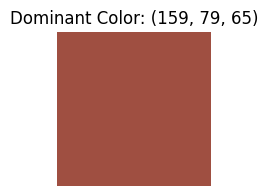

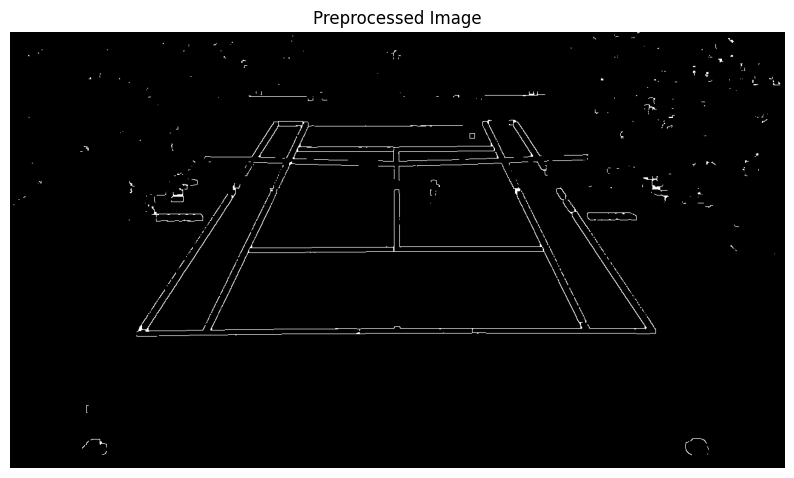

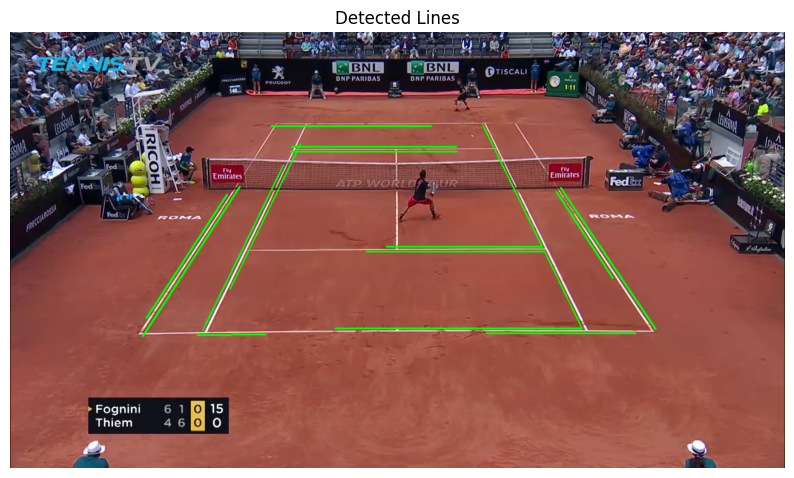

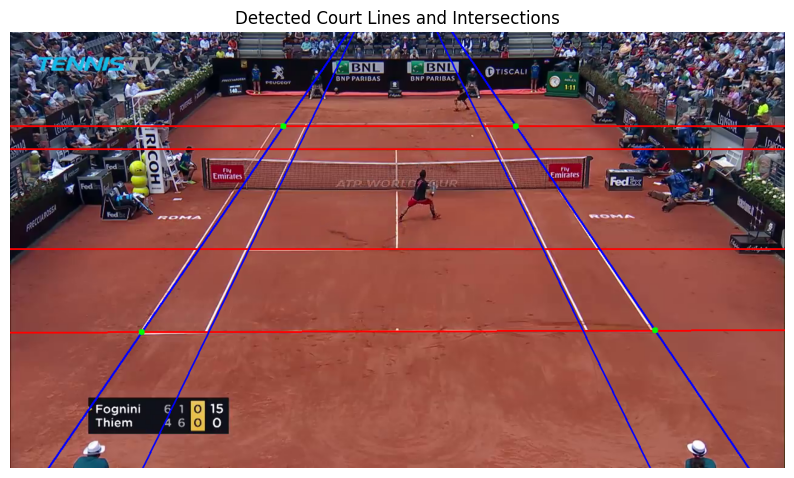

61.25

In [232]:
# test on random image
input_image, frame = get_random_image(data_court)
calculate_error(input_image, frame, plot=True)

In [225]:
# loop over entire dataset
def evaluate_hyperparameters(data):
    errors = []
    for subset in data['subsets']:
        for video in subset['videos']:
            for clip in video['clips']:
                for frame, value in clip['frames_with_objects'].items():
                    if value['split'] != 'test':
                        path = '../FinalDataset/' + subset['name'] + '/' + video['name'] + '/' + clip['name'] + '/' + frame +".jpg"
                        error = calculate_error(path, clip['frames_with_objects'][frame]['keypoints'][0]['points'])
                        errors.append(error)

    # calculate mean
    return sum(errors)/len(errors), errors

# Example usage
mean_error, errors = evaluate_hyperparameters(data_court)
mean_error

1125833.8121410992

In [226]:
# pprint the max distance
max_distance

{'value': 2409389.0, 'gt_point': [-200, 714], 'pred_point': (1350, 631)}